![Photo by Stephen Phillips - Hostreviews.co.uk on UnSplash](https://cf.bstatic.com/xdata/images/hotel/max1024x768/408003083.jpg?k=c49b5c4a2346b3ab002b9d1b22dbfb596cee523b53abef2550d0c92d0faf2d8b&o=&hp=1){fig-align="center" width=50%}


# Import data

In [1]:
from pathlib import Path

import catboost
import numpy as np
import pandas as pd
import shap
from IPython.display import clear_output
from lets_plot import *
from lets_plot.mapping import as_discrete
from sklearn import metrics, model_selection
from tqdm import tqdm

from data import pre_process, utils
from models import train_model

LetsPlot.setup_html()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


**Objective**:
- Evaluate the significance of features in the initial scraped dataset through:
  - Employing the feature_importances_ method of the CatBoostRegressor
  - Analyzing SHAP values
- Remove features that exhibit lower importance or predictive capability.



# Prepare dataframe before modelling
## Read in dataframe


In [2]:
df = pd.read_parquet(
    utils.Configuration.INTERIM_DATA_PATH.joinpath(
        "2023-10-01_Processed_dataset_for_NB_use.parquet.gzip"
    )
)

## Train-test split

The subsequent stage includes the train-test split. In this process, the data is divided into two sets: a training set and a testing set. The training set is employed for model training, while the testing set is reserved for model evaluation. This approach facilitates the training of models on the training set and subsequently assessing their accuracy on the unseen testing set. This enables us to impartially evaluate our model's performance using the test set, which was not utilized during the model training phase.

In [3]:
train, test = model_selection.train_test_split(
    df, test_size=0.2, random_state=utils.Configuration.seed
)

print(f"Shape of train: {train.shape}")
print(f"Shape of test: {test.shape}")

Shape of train: (2928, 56)
Shape of test: (732, 56)


## Preprocess dataframe for modelling

Our initial step involves the removal of features that lack informative value for our model, such as 'external_reference', 'ad_url', 'day_of_retrieval', 'website', 'reference_number_of_the_epc_report', 'housenumber'. Following this, we will apply a log transformation to our target variable. Additionally, we'll address missing values in categorical features by replacing them with the label "missing value." This particular step is necessary because while CatBoost can manage missing values in numerical columns, handling categorical missing values requires user intervention.able


In [6]:
processed_train = (
    train.reset_index(drop=True)
    .assign(price=lambda df: np.log10(df.price))  # Log transformation of 'price' column
    .drop(columns=utils.Configuration.features_to_drop)
)

# This step is needed since catboost cannot handle missing values when feature is categorical
for col in processed_train.columns:
    if processed_train[col].dtype.name in ("bool", "object", "category"):
        processed_train[col] = processed_train[col].fillna("missing value")

processed_train.shape

(2928, 50)

# Inspect feature importance

Evaluating feature importance can be accomplished through various methods. In this section, we have chosen to assess them using both the feature_importances_ attribute in CatBoost and SHAP values. To examine feature importance, we need to start by training a model. To facilitate this, we'll further partition the training set. By doing so, we reserve a portion of it for CatBoost training (validation dataset), allowing us to halt the training process when overfitting begins to occur.

In [7]:
features = processed_train.columns[~processed_train.columns.str.contains("price")]

numerical_features = processed_train.select_dtypes("number").columns.to_list()
categorical_features = processed_train.select_dtypes("object").columns.to_list()

train_FS, validation_FS = model_selection.train_test_split(
    processed_train, test_size=0.2, random_state=utils.Configuration.seed
)

# Get target variables
tr_y = train_FS[utils.Configuration.target_col]
val_y = validation_FS[utils.Configuration.target_col]

# Get feature matrices
tr_X = train_FS.loc[:, features]
val_X = validation_FS.loc[:, features]


print(f"Train dataset shape: {tr_X.shape} {tr_y.shape}")
print(f"Validation dataset shape: {val_X.shape} {val_y.shape}")

Train dataset shape: (2342, 49) (2342,)
Validation dataset shape: (586, 49) (586,)


In [8]:
train_dataset = catboost.Pool(tr_X, tr_y, cat_features=categorical_features)
validation_dataset = catboost.Pool(val_X, val_y, cat_features=categorical_features)

In [9]:
model = catboost.CatBoostRegressor(
    iterations=2000,
    random_seed=utils.Configuration.seed,
    loss_function="RMSE",
)

model.fit(
    train_dataset,
    eval_set=[validation_dataset],
    early_stopping_rounds=20,
    use_best_model=True,
    verbose=2000,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.038132
0:	learn: 0.3187437	test: 0.3148628	best: 0.3148628 (0)	total: 204ms	remaining: 6m 48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1087393065
bestIteration = 850

Shrink model to first 851 iterations.


In [10]:
# | fig-cap: "Assessing Feature Importance"
# | label: fig-fig1

(
    pd.concat(
        [pd.Series(model.feature_names_), pd.Series(model.feature_importances_)], axis=1
    )
    .sort_values(by=1, ascending=False)
    .rename(columns={0: "name", 1: "importance"})
    .reset_index(drop=True)
    .pipe(
        lambda df: ggplot(df, aes("name", "importance"))
        + geom_bar(stat="identity")
        + labs(
            title="Assessing Feature Importance",
            subtitle=""" based on the feature_importances_ attribute
            """,
            x="",
            y="Feature Importance",
            caption="https://www.immoweb.be/",
        )
        + theme(
            plot_subtitle=element_text(
                size=12, face="italic"
            ),  # Customize subtitle appearance
            plot_title=element_text(size=15, face="bold"),  # Customize title appearance
        )
        + ggsize(800, 600)
    )
)

# SHAP

SHAP (SHapley Additive exPlanations) values offer a method to elucidate the predictions made by any machine learning model. They adopt a game theoretic approach that quantifies the contribution of each "player" (feature) to the ultimate prediction. In the realm of machine learning, SHAP values assign an importance value to each feature, indicating its contribution to the model's output.

SHAP values provide insights into how each feature influences individual predictions, their relative significance when compared to one another, and the model's dependence on interactions between features. This holistic view enables a deeper understanding of the factors driving the model's decision In this section, our focus will be on computing SHAP values and then visualizing feature importance and feature dependencies using bar plots and beeswarm plots. These visualizations will provide us with a comprehensive understanding of how each feature influences our model's predictions and their interactions with one another.s.

In [9]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(
    catboost.Pool(tr_X, tr_y, cat_features=categorical_features)
)

The summary plot at @fig-fig2 provides a clear depiction of feature importance within the model. The outcomes reveal that "Living area," "Surface of the plot," and "Cadastral income" emerge as pivotal factors in influencing the model's predictions. These features prominently contribute to determining the model's results.

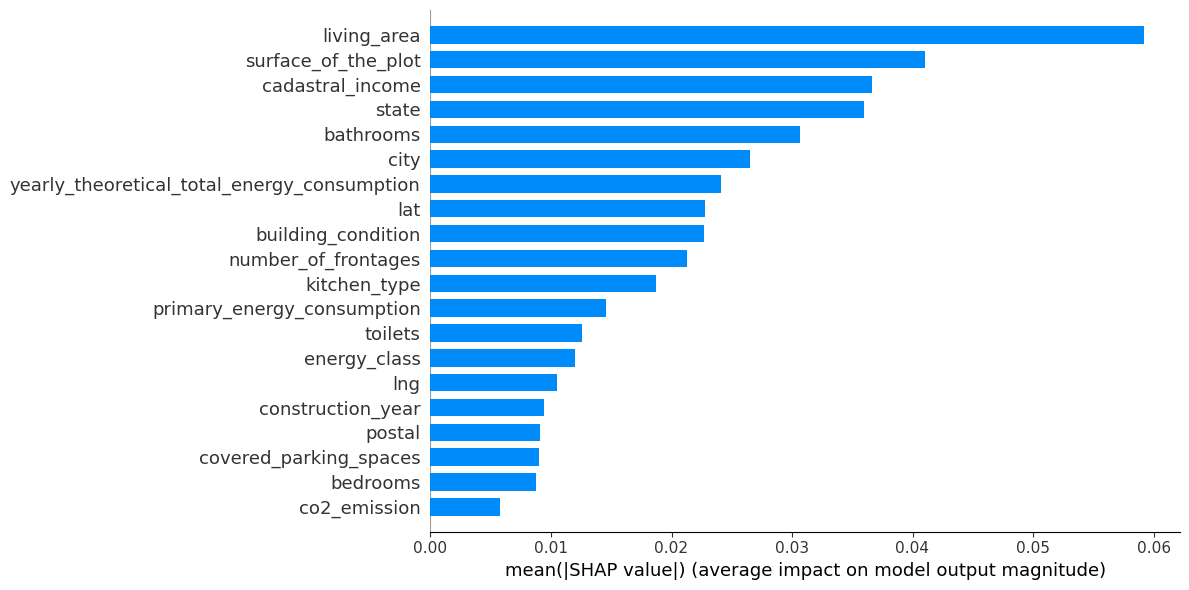

In [10]:
# | fig-cap: "Assessing Feature Importance using bar plot"
# | label: fig-fig2

shap.summary_plot(shap_values, tr_X, plot_type="bar", plot_size=[12, 6])

The beeswarm plot (@fig-fig3) is best understood with the following explanation:

- The Y-axis arranges the feature names in descending order of importance, with the most influential features at the top.
- The X-axis indicates the SHAP value, reflecting the impact of each feature on the model's output. Features on the right side of the plot have a stronger impact, while those on the left have a weaker impact.

Additionally:
- The color of each point on the graph corresponds to the value of the respective feature for that data point. Red denotes high values, and blue signifies low values.
- Each individual point on the plot represents a specific data row from the original dataset. These points collectively illustrate how different data points and their associated feature values contribute to the model's predictions, especially in relation to feature impo

When examining the "living area" feature, you'll notice that it predominantly exhibits a high positive SHAP value. This indicates that greater living area tends to have a positive effect on the output, which, in this context, is the price. Conversely, higher values of "primary energy consumption" are associated with a negative impact on the price, as reflected by their negative SHAP values.  

Also, it's important to take into account the spread of SHAP values and how it relates to their effect on predictive power. A broader spread or a denser distribution of data points suggests greater variability or a more substantial influence on the model's predictions. This insight allows us to assess the significance of features in terms of their contribution to the model's overall output.  

In this context, it becomes clear why "living area" holds greater importance when compared to "CO2 emission." The broader impact and higher variability of the "living area" feature in influencing the model's predictions make it a more crucial determinant of the output, which is why it carries more weight in the model's decision-making process.rtance.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


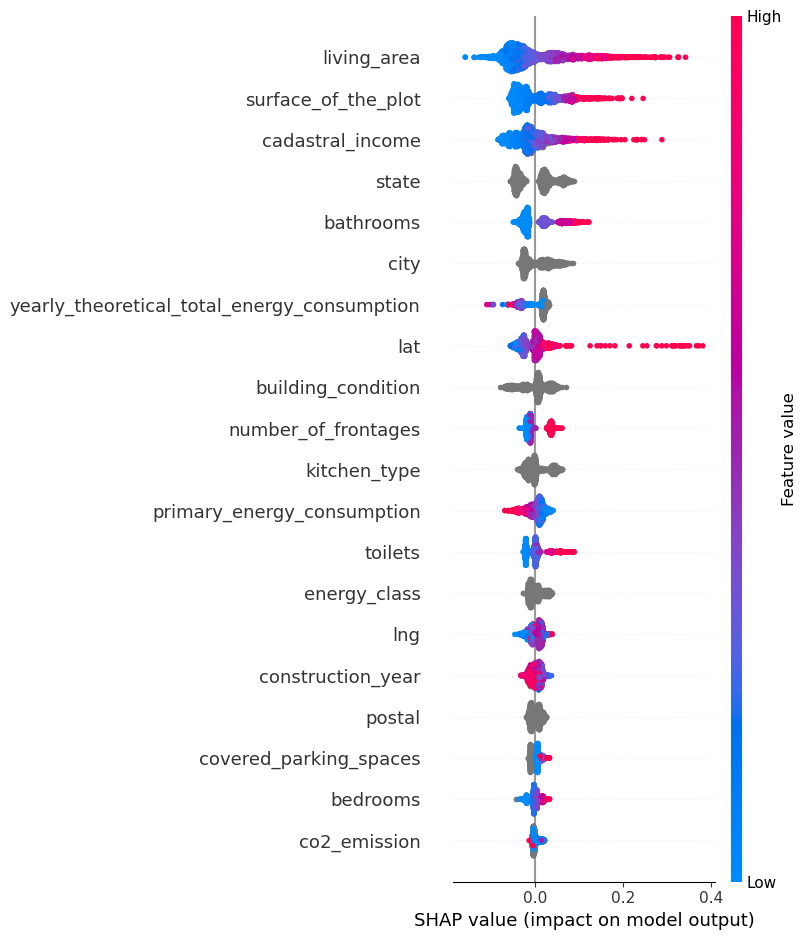

In [11]:
# | fig-cap: "Assessing Feature Importance using beeswarm plot"
# | label: fig-fig3

shap.summary_plot(shap_values, tr_X)

Let's examine the ranking or order of feature importances derived from both Gini impurity and SHAP values to understand how they compare and whether they yield similar or differing insights. As you can see they are fairly similar.

In [12]:
catboost_feature_importance = (
    pd.concat(
        [pd.Series(model.feature_names_), pd.Series(model.feature_importances_)], axis=1
    )
    .sort_values(by=1)
    .rename(columns={0: "catboost_name", 1: "importance"})
    .reset_index(drop=True)
)

In [13]:
shap_feature_importance = (
    pd.DataFrame(shap_values, columns=tr_X.columns)
    .abs()
    .mean()
    .sort_values()
    .reset_index()
    .rename(columns={"index": "shap_name", 0: "shap"})
)

In [14]:
pd.concat(
    [
        catboost_feature_importance.drop(columns="importance"),
        shap_feature_importance.drop(columns="shap"),
    ],
    axis=1,
)

,catboost_name,shap_name
0,flood_zone_type,flood_zone_type
1,dining_room,planning_permission_obtained
2,proceedings_for_breach_of_planning_regulations,proceedings_for_breach_of_planning_regulations
3,planning_permission_obtained,street_frontage_width
4,furnished,furnished
5,connection_to_sewer_network,double_glazing
6,possible_priority_purchase_right,dining_room
7,street_frontage_width,possible_priority_purchase_right
8,as_built_plan,connection_to_sewer_network
9,double_glazing,heating_type


# Recursive feature elimination based on SHAP values

Our next step involves the initial feature elimination process based on SHAP values, and we'll use Catboost's `select_features` method to do so. Initially, we began with approximately 50 features. While having a rich set of features can be advantageous, we must also consider the need for model interpretability.

With this step, our goal is to remove features that don't significantly contribute to the final predictive output and retain only the most influential features. This helps streamline our model and enhances its interpretability, making it easier to understand the factors driving its predictions.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.0582
Step #1 out of 10
0:	learn: 0.3152318	test: 0.3115119	best: 0.3115119 (0)	total: 40.4ms	remaining: 40.4s
250:	learn: 0.0875657	test: 0.1143850	best: 0.1143850 (250)	total: 10.6s	remaining: 31.7s
500:	learn: 0.0676185	test: 0.1092529	best: 0.1092412 (497)	total: 21s	remaining: 20.9s
750:	learn: 0.0567661	test: 0.1072066	best: 0.1072004 (749)	total: 31.8s	remaining: 10.5s
999:	learn: 0.0474957	test: 0.1066737	best: 0.1065423 (961)	total: 41.9s	remaining: 0us

bestTest = 0.1065422651
bestIteration = 961

Shrink model to first 962 iterations.
Feature #38 eliminated
Feature #28 eliminated
Feature #20 eliminated
Feature #22 eliminated
Feature #19 eliminated
Feature #14 eliminated
Feature #11 eliminated
Feature #0 eliminated
Feature #31 eliminated
Feature #15 eliminated
Feature #30 eliminated
Feature #41 eliminated
Feature #33 eliminated
Feature #17 eliminated
Feature #45 eliminated
Feature #18 eliminated
Step #2 out of 10
0:	learn: 0.3155660	test: 0.3112354	best: 

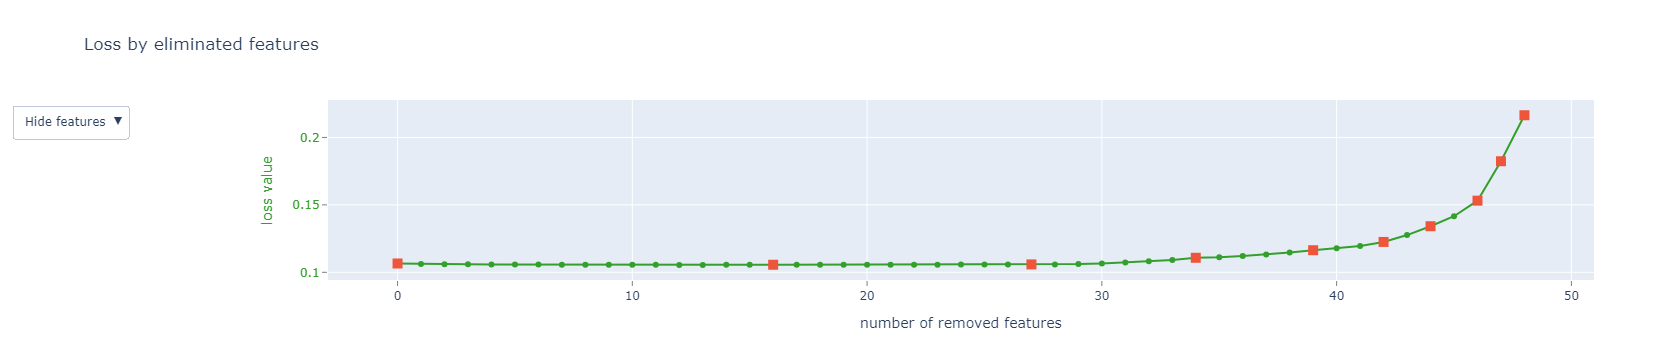

In [22]:
regressor = catboost.CatBoostRegressor(
    iterations=1000,
    cat_features=categorical_features,
    random_seed=utils.Configuration.seed,
    loss_function="RMSE",
)

rfe_dict = regressor.select_features(
    algorithm="RecursiveByShapValues",
    shap_calc_type="Exact",
    X=tr_X,
    y=tr_y,
    eval_set=(val_X, val_y),
    features_for_select="0-48",
    num_features_to_select=1,
    steps=10,
    verbose=250,
    train_final_model=False,
    plot=True,
)

By employing Recursive Feature Elimination, we've managed to significantly reduce the number of features from an initial count of 49 to a streamlined set of 17, which includes the "bedrooms" feature. Remarkably, this feature reduction hasn't significantly impacted our model's performance, allowing us to maintain a similar level of predictive accuracy. This process enhances model simplicity and interpretability without compromising effectiveness.

In [26]:
features_to_keep = (
    rfe_dict["eliminated_features_names"][33:] + rfe_dict["selected_features_names"]
)

print(features_to_keep)

['bedrooms', 'state', 'kitchen_type', 'number_of_frontages', 'toilets', 'street', 'lng', 'primary_energy_consumption', 'bathrooms', 'yearly_theoretical_total_energy_consumption', 'surface_of_the_plot', 'building_condition', 'city', 'lat', 'cadastral_income', 'living_area']


In the upcoming notebook, we'll delve into the task of identifying outliers in our dataset. Should we detect any outliers, we will carefully consider how to address them to ensure they don't unduly influence our model's performance.

Additionally, we'll explore several additional feature engineering steps aimed at further enhancing our model's performance. This process will be carried out within the framework of cross-validation, ensuring that our model is robust and reliable. This iterative approach will help us optimize our model and improve its predictive power. See you there!